# Experiment 3: Train WikiArt Text-to-Image Diffusion Model

This notebook trains a text-to-image diffusion model on the WikiArt dataset using classifier-free guidance (CFG).

**Key Differences from Experiment 2 (CIFAR-10):**
- **Image size:** 128×128 (vs 32×32)
- **Classes:** 27 art styles (vs 10 object categories)
- **Dataset:** HuggingFace WikiArt dataset
- **Model capacity:** Larger UNet (5 blocks vs 4) for complex artistic images
- **Training:** More epochs (100 vs 50), smaller batch size (16 vs 128)

**Model Architecture:**
- Custom UNet2DConditionModel for 128×128 RGB
- CLIP text encoder for text conditioning
- Classifier-free guidance during training (10% dropout)

**Training Configuration:**
- 100 epochs
- Batch size: 16 (memory constraints for larger images)
- Learning rate: 1e-5
- Checkpoints every 10 epochs

## 1. Setup and Configuration

In [1]:
# Project configuration - use absolute paths
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [2]:
# Import configuration
from config import (
    EXPERIMENT_3_CONFIG,
    TRAIN_WIKIART_CONFIG,
    INFERENCE_CONFIG,
    UNET_WIKIART_CONFIG,
    TOKENIZER_MAX_LENGTH,
    CLIP_MODEL_NAME,
    WIKIART_STYLES,
    CHECKPOINTS_DIR,
    DATASET_CACHE_DIR,
    UNET_WIKIART_CHECKPOINT_PREFIX,
    get_wikiart_unet_checkpoint_path,
    get_latest_wikiart_unet_checkpoint,
    ensure_experiment_3_dirs,
)

# Deep learning frameworks
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random

# HuggingFace datasets
from datasets import load_dataset
import torchvision.transforms as transforms
from PIL import Image

print("Libraries imported successfully")

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# Print configuration
print("WikiArt Training Configuration:")
print(f"  Styles: {len(WIKIART_STYLES)} art styles")
print(f"  Epochs: {TRAIN_WIKIART_CONFIG['num_epochs']}")
print(f"  Batch size: {TRAIN_WIKIART_CONFIG['batch_size']}")
print(f"  Learning rate: {TRAIN_WIKIART_CONFIG['learning_rate']}")
print(f"  Checkpoint every: {TRAIN_WIKIART_CONFIG['checkpoint_every_n_epochs']} epochs")
print()
print("UNet Configuration:")
print(f"  Sample size: {UNET_WIKIART_CONFIG['sample_size']}")
print(f"  Channels: {UNET_WIKIART_CONFIG['in_channels']}")
print(f"  Block channels: {UNET_WIKIART_CONFIG['block_out_channels']}")
print()
print("Art Styles:")
for i, style in enumerate(WIKIART_STYLES):
    print(f"  {i}: {style}")

WikiArt Training Configuration:
  Styles: 27 art styles
  Epochs: 100
  Batch size: 16
  Learning rate: 1e-05
  Checkpoint every: 10 epochs

UNet Configuration:
  Sample size: 128
  Channels: 3
  Block channels: (128, 256, 512, 512, 512)

Art Styles:
  0: Abstract_Expressionism
  1: Action_painting
  2: Analytical_Cubism
  3: Art_Nouveau_Modern
  4: Baroque
  5: Color_Field_Painting
  6: Contemporary_Realism
  7: Cubism
  8: Early_Renaissance
  9: Expressionism
  10: Fauvism
  11: High_Renaissance
  12: Impressionism
  13: Mannerism_Late_Renaissance
  14: Minimalism
  15: Naive_Art_Primitivism
  16: New_Realism
  17: Northern_Renaissance
  18: Pointillism
  19: Pop_Art
  20: Post_Impressionism
  21: Realism
  22: Rococo
  23: Romanticism
  24: Symbolism
  25: Synthetic_Cubism
  26: Ukiyo_e


In [4]:
# Create directories
ensure_experiment_3_dirs()
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
print("Directory structure created")

Directory structure created


## 2. Download WikiArt Dataset from HuggingFace

**Two-step process:**
1. **Download:** Explicitly download dataset files to cache
2. **Load:** Load dataset from cached files for training

This approach provides better progress visibility and debugging.

In [5]:
# Configure HuggingFace cache directories
import os
os.environ['HF_HOME'] = str(PROJECT_ROOT / "dataset_cache" / "huggingface")
os.environ['HF_DATASETS_CACHE'] = str(DATASET_CACHE_DIR)

print("="*70)
print("Step 1: Download WikiArt Dataset")
print("="*70)
print(f"Cache directory: {DATASET_CACHE_DIR}")
print(f"HF_HOME: {os.environ['HF_HOME']}\n")

# Test connectivity
print("Testing HuggingFace connectivity...")
try:
    import requests
    response = requests.get("https://huggingface.co", timeout=10)
    print(f"✓ Can reach huggingface.co (status: {response.status_code})\n")
except Exception as e:
    print(f"✗ Connection failed: {e}")
    print("⚠ You may be on an HPC login node with restricted network access")
    print("  Consider submitting a compute node job to download the dataset\n")

# Clean up any incomplete cache
import shutil
incomplete_dir = DATASET_CACHE_DIR / "huggan___wikiart"
if incomplete_dir.exists():
    print("Cleaning incomplete cache...")
    for item in incomplete_dir.rglob("*.incomplete"):
        if item.is_dir():
            print(f"  Removing: {item.name}")
            shutil.rmtree(item)
    print()

# Download using huggingface-cli for better progress tracking
print("Downloading WikiArt dataset using huggingface-cli...")
print("This may take 10-30 minutes for ~15GB dataset\n")

import subprocess
import time

start_time = time.time()

# Use huggingface-cli to download dataset with progress bars
download_cmd = [
    "huggingface-cli",
    "download",
    "huggan/wikiart",
    "--repo-type", "dataset",
    "--local-dir", str(DATASET_CACHE_DIR / "huggingface" / "downloads" / "wikiart"),
    "--cache-dir", str(DATASET_CACHE_DIR / "huggingface"),
]

try:
    print(f"Running: {' '.join(download_cmd)}\n")
    result = subprocess.run(
        download_cmd,
        check=True,
        capture_output=False,  # Show output in real-time
        text=True,
        timeout=3600  # 1 hour timeout
    )
    
    elapsed = time.time() - start_time
    print(f"\n{'='*70}")
    print(f"✓ Dataset downloaded successfully!")
    print(f"{'='*70}")
    print(f"Download time: {elapsed/60:.1f} minutes")
    print(f"Location: {DATASET_CACHE_DIR / 'huggingface' / 'downloads' / 'wikiart'}")
    
except subprocess.TimeoutExpired:
    print("\n✗ Download timed out after 1 hour")
    print("The network connection may be too slow or unstable")
    
except subprocess.CalledProcessError as e:
    print(f"\n✗ Download failed with error code {e.returncode}")
    print("\nAlternative: Use Python API for download")
    print("This may not show progress but will work:")
    print()
    
    # Fallback: try with datasets API
    try:
        from datasets import load_dataset_builder
        
        print("Attempting download with datasets API...")
        builder = load_dataset_builder("huggan/wikiart", cache_dir=str(DATASET_CACHE_DIR))
        builder.download_and_prepare()
        
        elapsed = time.time() - start_time
        print(f"\n✓ Dataset prepared successfully!")
        print(f"Time: {elapsed/60:.1f} minutes")
        
    except Exception as e2:
        print(f"\n✗ Both download methods failed: {e2}")
        print("\nRecommendation: Submit SLURM job on compute node")
        raise

except FileNotFoundError:
    print("✗ huggingface-cli not found")
    print("Falling back to datasets API...\n")
    
    # Fallback: Use datasets API
    from datasets import load_dataset_builder
    
    try:
        print("Downloading with datasets library...")
        builder = load_dataset_builder("huggan/wikiart", cache_dir=str(DATASET_CACHE_DIR))
        builder.download_and_prepare()
        
        elapsed = time.time() - start_time
        print(f"\n✓ Dataset prepared successfully!")
        print(f"Time: {elapsed/60:.1f} minutes")
        
    except Exception as e:
        print(f"\n✗ Download failed: {e}")
        raise


Step 1: Download WikiArt Dataset
Cache directory: /home/doshlom4/work/final_project/dataset_cache
HF_HOME: /home/doshlom4/work/final_project/dataset_cache/huggingface

Testing HuggingFace connectivity...
✓ Can reach huggingface.co (status: 200)

This may take 10-30 minutes for ~15GB dataset

Running: huggingface-cli download huggan/wikiart --repo-type dataset --local-dir /home/doshlom4/work/final_project/dataset_cache/huggingface/downloads/wikiart --cache-dir /home/doshlom4/work/final_project/dataset_cache/huggingface

⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.
/RG/rg-miray/doshlom4/final_project/dataset_cache/huggingface/downloads/wikiart

✓ Dataset downloaded successfully!
Download time: 0.0 minutes
Location: /home/doshlom4/work/final_project/dataset_cache/huggingface/downloads/wikiart


Fetching 75 files: 100%|█████████████████████| 75/75 [00:00<00:00, 1534.86it/s]


In [6]:
# Step 2: Create custom dataset loader (no HuggingFace datasets library)
print("="*70)
print("Step 2: Custom WikiArt Dataset Loader")
print("="*70)

import pandas as pd
from pathlib import Path
import os

# Check what files we have in the dataset cache
dataset_path = DATASET_CACHE_DIR / "huggingface" / "downloads" / "wikiart" / "data"
print(f"Looking for dataset files in: {dataset_path}\n")

if dataset_path.exists():
    files = list(dataset_path.glob("*"))
    print(f"Found {len(files)} files:")
    for f in files[:10]:  # Show first 10
        size_mb = f.stat().st_size / (1024**2) if f.is_file() else 0
        print(f"  {f.name} ({size_mb:.1f} MB)")
    if len(files) > 10:
        print(f"  ... and {len(files) - 10} more files")
else:
    print(f"⚠ Dataset path does not exist: {dataset_path}")
    print("Run the download cell first!")

print(f"\n{'='*70}")

Step 2: Custom WikiArt Dataset Loader
Looking for dataset files in: /home/doshlom4/work/final_project/dataset_cache/huggingface/downloads/wikiart/data

Found 72 files:
  train-00011-of-00072.parquet (514.2 MB)
  train-00059-of-00072.parquet (289.7 MB)
  train-00004-of-00072.parquet (507.5 MB)
  train-00067-of-00072.parquet (415.9 MB)
  train-00010-of-00072.parquet (505.5 MB)
  train-00005-of-00072.parquet (495.1 MB)
  train-00066-of-00072.parquet (427.6 MB)
  train-00058-of-00072.parquet (342.0 MB)
  train-00038-of-00072.parquet (433.2 MB)
  train-00065-of-00072.parquet (418.3 MB)
  ... and 62 more files



In [7]:
# Define transforms - resize to 128x128 and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # RGB normalization to [-1, 1]
])

print("Transform defined: Resize(128x128) -> ToTensor -> Normalize to [-1, 1]")

Transform defined: Resize(128x128) -> ToTensor -> Normalize to [-1, 1]


In [8]:
# Import custom WikiArt dataset class from project file
# Use IterableDataset for FAST file-sequential loading
from wikiart_dataset_custom import WikiArtIterableDataset

# Create the custom dataset
dataset_dir = DATASET_CACHE_DIR / "huggingface" / "downloads" / "wikiart" / "data"

try:
    train_dataset = WikiArtIterableDataset(
        dataset_dir,
        transform=transform,
        prompt_template=EXPERIMENT_3_CONFIG["prompt_template"],
        styles_list=WIKIART_STYLES,
        shuffle_files=True,    # Shuffle file order each epoch
        shuffle_samples=True,  # Shuffle samples within each file
    )
    
    print(f"\n{'='*70}")
    print(f"✓ WikiArt IterableDataset created!")
    print(f"  - Loads one file at a time (~400MB, ~1100 samples)")
    print(f"  - Shuffles within each file (fast, memory efficient)")
    print(f"  - File order shuffled each epoch")
    print(f"{'='*70}")
    
except Exception as e:
    print(f"\n✗ Failed to create dataset: {e}")
    import traceback
    traceback.print_exc()
    raise

Indexing parquet files...
  Indexed 10/72 files (11,320 samples)
  Indexed 20/72 files (22,632 samples)
  Indexed 30/72 files (33,942 samples)
  Indexed 40/72 files (45,252 samples)
  Indexed 50/72 files (56,562 samples)
  Indexed 60/72 files (67,872 samples)
  Indexed 70/72 files (79,182 samples)
  Indexed 72/72 files (81,444 samples)

✓ WikiArtIterableDataset ready with 81,444 samples
  Files: 72 parquet files
  Shuffle files: True, Shuffle samples: True

✓ WikiArt IterableDataset created!
  - Loads one file at a time (~400MB, ~1100 samples)
  - Shuffles within each file (fast, memory efficient)
  - File order shuffled each epoch


In [9]:
# Create DataLoader for IterableDataset
# Note: shuffle=False (shuffling is handled inside the dataset)
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_WIKIART_CONFIG["batch_size"],
    shuffle=False,  # IterableDataset handles its own shuffling
    num_workers=0,  # Single process (dataset loads one file at a time)
    pin_memory=True,
)

print(f"✓ DataLoader created for IterableDataset")
print(f"  Total samples: {len(train_dataset):,}")
print(f"  Batch size: {TRAIN_WIKIART_CONFIG['batch_size']}")
print(f"  Expected batches per epoch: ~{len(train_dataset) // TRAIN_WIKIART_CONFIG['batch_size']:,}")
print(f"  Workers: 0 (file-sequential loading)")
print(f"  Memory: ~400MB per file (loaded one at a time)")

✓ DataLoader created for IterableDataset
  Total samples: 81,444
  Batch size: 16
  Expected batches per epoch: ~5,090
  Workers: 0 (file-sequential loading)
  Memory: ~400MB per file (loaded one at a time)


In [10]:
# Test the streaming dataloader - fetch a few batches to verify it works
print("="*70)
print("Testing Streaming DataLoader")
print("="*70)
print("Fetching first 3 batches to verify streaming is working...\n")

import time

batch_count = 0
max_batches = 3

start_time = time.time()

for batch_idx, (images, captions, labels) in enumerate(train_loader):
    if batch_idx >= max_batches:
        break
    
    batch_time = time.time() - start_time
    
    print(f"Batch {batch_idx + 1}:")
    print(f"  Images shape: {images.shape}")
    print(f"  Batch size: {images.shape[0]}")
    print(f"  Sample captions: {captions[:2]}")
    print(f"  Sample labels: {labels[:5].tolist()}")
    print(f"  Fetch time: {batch_time:.2f}s")
    print(f"  Image range: [{images.min():.2f}, {images.max():.2f}]")
    print()
    
    batch_count += 1
    start_time = time.time()  # Reset for next batch

total_images = batch_count * images.shape[0]
print(f"{'='*70}")
print(f"✓ Streaming DataLoader is working!")
print(f"{'='*70}")
print(f"Fetched {batch_count} batches ({total_images} images)")
print(f"Data is streamed on-demand - no full dataset in RAM")
print(f"{'='*70}")

Testing Streaming DataLoader
Fetching first 3 batches to verify streaming is working...

Batch 1:
  Images shape: torch.Size([16, 3, 128, 128])
  Batch size: 16
  Sample captions: ['A painting in the style of Art Nouveau Modern', 'A painting in the style of Symbolism']
  Sample labels: [3, 24, 3, 24, 3]
  Fetch time: 1.74s
  Image range: [-1.00, 0.99]

Batch 2:
  Images shape: torch.Size([16, 3, 128, 128])
  Batch size: 16
  Sample captions: ['A painting in the style of Post Impressionism', 'A painting in the style of Impressionism']
  Sample labels: [20, 12, 21, 15, 9]
  Fetch time: 0.79s
  Image range: [-0.98, 0.97]

Batch 3:
  Images shape: torch.Size([16, 3, 128, 128])
  Batch size: 16
  Sample captions: ['A painting in the style of Baroque', 'A painting in the style of Baroque']
  Sample labels: [4, 4, 12, 20, 12]
  Fetch time: 0.74s
  Image range: [-1.00, 1.00]

✓ Streaming DataLoader is working!
Fetched 3 batches (48 images)
Data is streamed on-demand - no full dataset in RAM


Visualizing Samples from First Batch
Batch info:
  Shape: torch.Size([16, 3, 128, 128])
  Device: cpu
  Dtype: torch.float32
  ⏱️  Loading time: 1.41s (88.2ms per image)



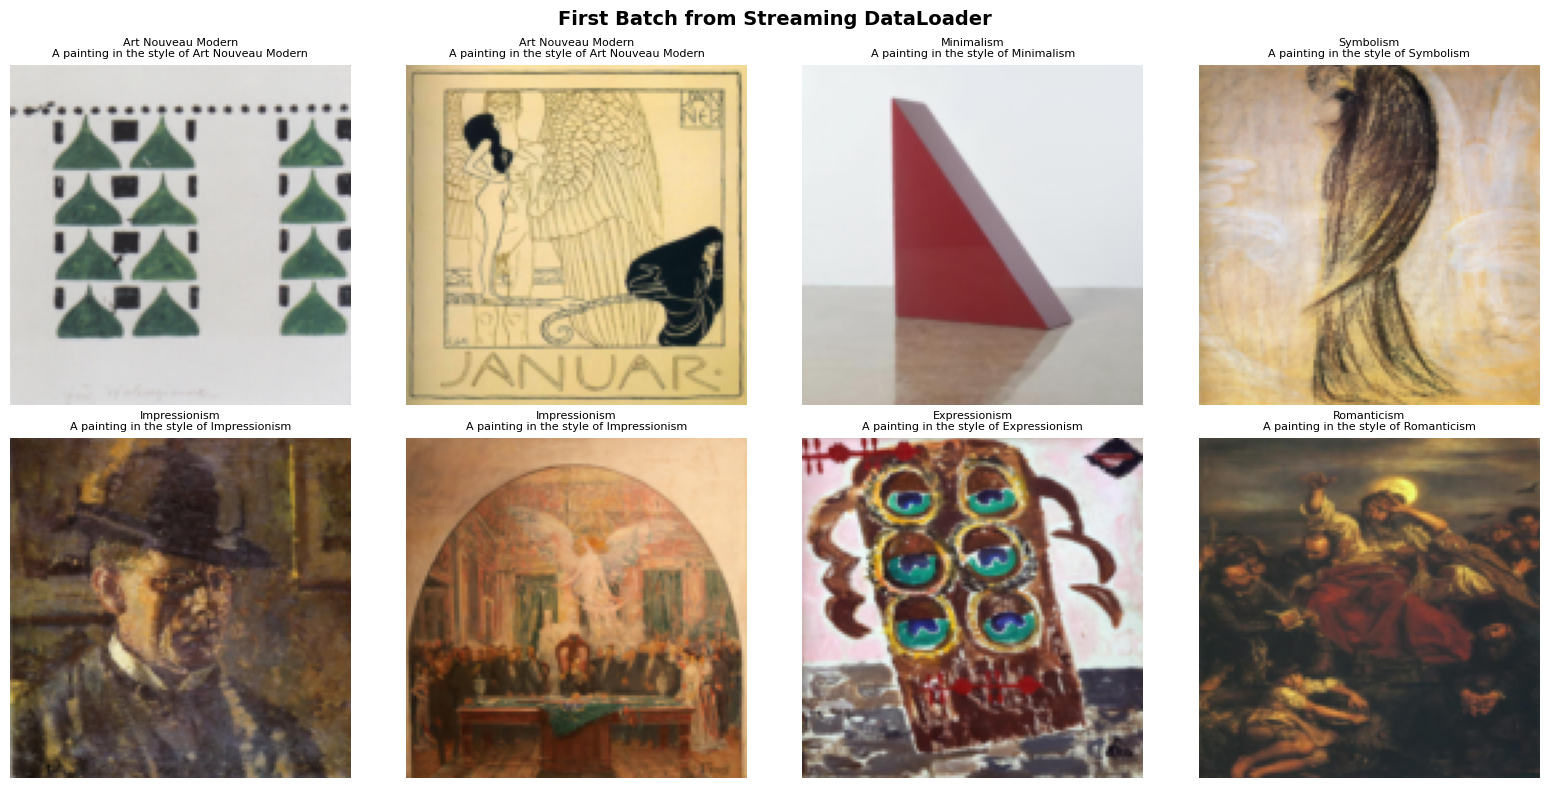

✓ Successfully visualized 8 samples
  ⏱️  Visualization time: 0.19s
  ⏱️  Total time: 1.60s


In [11]:
# Visualize samples from the first batch
print("="*70)
print("Visualizing Samples from First Batch")
print("="*70)

import time

# Time the batch loading
batch_start = time.time()
batch_images, batch_captions, batch_labels = next(iter(train_loader))
batch_time = time.time() - batch_start

print(f"Batch info:")
print(f"  Shape: {batch_images.shape}")
print(f"  Device: {batch_images.device}")
print(f"  Dtype: {batch_images.dtype}")
print(f"  ⏱️  Loading time: {batch_time:.2f}s ({batch_time/batch_images.shape[0]*1000:.1f}ms per image)")
print()

# Visualize first 8 images from the batch
viz_start = time.time()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

num_viz = min(8, batch_images.shape[0])
for i, ax in enumerate(axes.flat[:num_viz]):
    # Denormalize image from [-1, 1] to [0, 1]
    img = batch_images[i].cpu().permute(1, 2, 0)
    img = (img + 1) / 2  # [-1, 1] -> [0, 1]
    img = torch.clamp(img, 0, 1)
    
    ax.imshow(img)
    
    # Show caption and style
    caption = batch_captions[i][:60]  # Show more of caption
    label = batch_labels[i].item()
    style = WIKIART_STYLES[label] if label < len(WIKIART_STYLES) else f"Label {label}"
    
    # Clean style name for display (replace underscores)
    style_display = style.replace("_", " ")
    
    ax.set_title(f"{style_display}\n{caption}", fontsize=8)
    ax.axis('off')

plt.suptitle('First Batch from Streaming DataLoader', fontsize=14, fontweight='bold')
plt.tight_layout()

viz_time = time.time() - viz_start
plt.show()

print(f"✓ Successfully visualized {num_viz} samples")
print(f"  ⏱️  Visualization time: {viz_time:.2f}s")
print(f"  ⏱️  Total time: {batch_time + viz_time:.2f}s")